# Setup and references

In [1]:
## IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
results_dir = r"#" #Directory to save to

In [3]:
extensPath = r"#" #CSV file for extensometry data (CSV)

In [4]:
dic_dir = r"#" #Directory for DIC data files (CSV)

# Read extensometry, identify start/end of test

In [5]:
df1 = pd.read_csv(extensPath, delimiter = ';', skiprows = range(0,2), names = ['DIC Image Index', 'Load [N]'], usecols = [4,5])

In [6]:
df1

DIC Image Index   Load [N]
0                  1  17.674854
1                  2  17.629330
2                  3  17.126985
3                  4  18.450607
4                  5  17.654328
..               ...        ...
988              989   6.265651
989              990   6.227495
990              991   6.248283
991              992   6.215390
992              993   6.243810

[993 rows x 2 columns]

In [7]:
# IDENTIFY START AND END OF TEST (CRITERIA USE CHANGE IN LOAD)
load_list = df1['Load [N]'].tolist()
load_change = []
for i in range(len(load_list)):
	if i == 0:
		change = 0
	elif i != 0:
		change = load_list[i] - load_list[i-1]
	load_change.append(change)
df1['load change']=load_change

# Start of test: (First dL>2 index)-1 index
df_temp = df1.drop(df1[df1['load change'] <2].index)
start_index = df_temp.index[0] - 1
start_image = start_index+1

# End of test: (First dl<-50 index)-1 index
df_temp = df1.drop(df1[df1['load change'] > -50].index)
end_index = df_temp.index[0] - 1
end_image = end_index+1

df2=df1
indexDrop = list(range(0,start_index,1)) + list(range(end_index+1,len(df2.index),1))
df2 = df2.drop(indexDrop) # Trim data to start of test
df2 = df2.drop(axis=1, labels=['load change', 'DIC Image Index'])

In [8]:
df2

Load [N]
129   21.252318
130   23.399059
131   25.671848
132   28.057262
133   30.512148
..          ...
819  481.886250
820  479.151120
821  476.965170
822  475.034210
823  471.975670

[695 rows x 1 columns]

# Read DIC data

In [9]:
# ESTABLISH DIC DATA FILE NAMES
extens_last = len(df1.index)
if extens_last < 1000:
	dicNames = []
	for i in range(start_image, end_image+1, 1):
		if i < 10:
			i_name = '00'+str(i)
		elif 10 <= i < 100:
			i_name = '0'+str(i)
		elif 100 <= i < 1000:
			i_name = str(i)
		dicNames.append(i_name)
elif extens_last >= 1000:
	dicNames = []
	for i in range(start_image, end_image+1, 1):
		if i < 10:
			i_name = '000'+str(i)
		elif 10 <= i < 100:
			i_name = '00'+str(i)
		elif 100 <= i < 1000:
			i_name = '0'+str(i)
		elif 1000 <= i < 10000:
			i_name = str(i)
		dicNames.append(i_name)
elif extens_last >= 10000:
	exit()

dicFiles = []
for dicName in dicNames:
	dicFile = str(dic_dir + '/data_' + dicName + '.csv')
	dicFiles.append(dicFile)

In [10]:
#FIND CO-ORDINATES FOR DISPLACEMENT MEASUREMENT
data =  pd.read_csv(dicFiles[0], skiprows=1, encoding = 'latin1', names=['xc','yc','zc','strain'], usecols = [0,1,2,19])

# Find x reference point (between notches)
x = data['xc'].tolist()
x_min = min(x)
x_max = max(x)
x_mid = ((x_max - x_min)/2) + x_min
x_u = list(set(x))
x_u.sort()
x_u_mid = min(x_u, key=lambda x:abs(x-x_mid))
x_base = x_u.index(x_u_mid)

# find y reference point (between notches)
drop_hi = data[data['yc'] > 6].index #Note, working from the original dataset again
data3 = data.drop(drop_hi)
drop_lo = data[data['yc'] < -2].index
data3 = data3.drop(drop_lo)

y = data3['yc'].tolist()
y_u = list(set(y))
y_u.sort()

x_list = []
for y in y_u:
    x_sub_list=[]
    y_indexes = list(data3[data3['yc'] == y].index)
    for i in y_indexes:
        x = data.at[i,'xc']
        x_sub_list.append(x)
    x_list.append(x_sub_list) #This is a list of all the x-coordinates at that y co-ordinate

x_length = []
for i in x_list:
    x_length.append(len(i)) #For each y co-ordinate, these are the x co-ordinates

x_len_min = min(x_length)
x_len_min_index = []
for i in range(len(x_length)):
    if x_length[i] == x_len_min:
        x_len_min_index.append(i)
x_mid_index = int(round((x_len_min_index[-1] + x_len_min_index[0])/2,0))
y_base_val = y_u[x_mid_index] #This is the y value for the notch root
y_base = y_u.index(y_base_val)

x = x_u_mid
y1 = y_base_val - 5
y2 = y_base_val + 5

In [11]:
y2-y1

10.0

In [12]:
# Read displacement from DIC files
print('Displacement data being read from CSV files, please wait... ')
d1_list = []
d2_list = []
for dicFile in dicFiles:
    data =  pd.read_csv(dicFile, skiprows=1, encoding = 'latin1', names=['xc','yc','yd'], usecols = [0,1,4])
    # Get index for (x1,y1)
    temp_df = data.iloc[(data['xc'] - x).abs().argsort()[:1]]
    temp_df.reset_index(inplace=True)
    x_ref = temp_df.at[0,'xc']

    data1 = data.drop(data[data['xc'] != x_ref].index)
    temp_df = data1.iloc[(data1['yc'] - y1).abs().argsort()[:1]]
    temp_df.reset_index(inplace=True)
    y1_ref = temp_df.at[0, 'yc']

    temp_df = data.drop(data[data['xc'] != x_ref].index.tolist())
    temp_df = temp_df.drop(temp_df[temp_df['yc'] != y1_ref].index.tolist())
    index1 = temp_df.index.values[0]

    # Get index for (x2,y2)
    data1 = data.drop(data[data['xc'] != x_ref].index)
    temp_df = data1.iloc[(data1['yc'] - y2).abs().argsort()[:1]]
    temp_df.reset_index(inplace=True)
    y2_ref = temp_df.at[0, 'yc']

    temp_df = data.drop(data[data['xc'] != x_ref].index.tolist())
    temp_df = temp_df.drop(temp_df[temp_df['yc'] != y2_ref].index.tolist())
    index2 = temp_df.index.values[0]

    # Displacements
    d1 = data.at[index1, 'yd']
    d2 = data.at[index2, 'yd']
    d1_list.append(d1)
    d2_list.append(d2)
    print('read '+dicFile)

Displacement data being read from CSV files, please wait... 
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_130.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_131.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_132.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_133.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_134.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_135.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_136.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_137.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_138.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_139.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dic

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_225.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_226.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_227.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_228.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_229.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_230.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_231.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_232.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_233.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_234.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_235.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_322.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_323.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_324.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_325.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_326.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_327.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_328.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_329.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_330.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_331.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_332.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_417.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_418.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_419.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_420.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_421.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_422.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_423.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_424.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_425.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_426.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_427.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_513.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_514.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_515.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_516.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_517.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_518.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_519.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_520.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_521.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_522.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_523.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_609.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_610.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_611.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_612.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_613.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_614.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_615.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_616.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_617.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_618.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_619.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_705.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_706.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_707.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_708.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_709.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_710.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_711.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_712.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_713.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_714.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_715.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_802.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_803.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_804.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_805.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_806.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_807.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_808.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_809.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_810.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_811.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_812.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

In [13]:
y2_ref - y1_ref

10.001560999999999

In [14]:
d_list = []
for i in range(len(d1_list)):
    d = d2_list[i] - d1_list[i]
    d_list.append(d)

In [15]:
df3 = df2
df3['Displacement [mm]'] = d_list
df3.columns = ['Exp Force [N]', 'Displacement [mm]']

In [16]:
df3

Exp Force [N]  Displacement [mm]
129      21.252318           0.000364
130      23.399059           0.000287
131      25.671848           0.000413
132      28.057262           0.000572
133      30.512148           0.000711
..             ...                ...
819     481.886250           0.437881
820     479.151120           0.438905
821     476.965170           0.439830
822     475.034210           0.440908
823     471.975670           0.441914

[695 rows x 2 columns]

# Condition data for input to validation process

In [17]:
# REMOVE POINTS WITH NEGATIVE DISPLACEMENT
df3 = df3.drop(df3[df3['Displacement [mm]'] < 0].index)
df3 = df3.reset_index(drop=True)

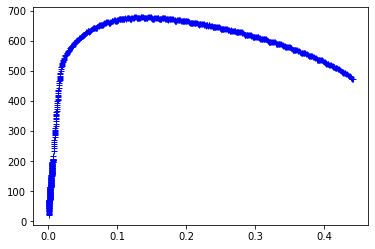

In [18]:
plt.plot(df3['Displacement [mm]'], df3['Exp Force [N]'], 'b+')

## Select sampling points

### Trim out elastic datapoints

In [19]:
temp = df3[df3['Exp Force [N]'] < 200]
divisor = round(len(temp)/10)
todrop = []
for i in temp.index.values:
    if i%divisor == 0:
        pass
    else:
        todrop.append(i)
df3 = df3.drop(todrop)
df3 = df3.reset_index(drop=True)

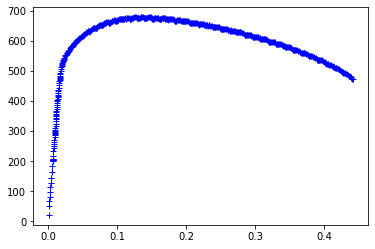

In [20]:
plt.plot(df3['Displacement [mm]'], df3['Exp Force [N]'], 'b+')

### Overall sampling

In [25]:
df4 = df3

diffs = []
for i in range(len(df4.index)):
    if i == 0:
        diffs.append(np.NaN)
    else:
        dy = df4.at[i, 'Exp Force [N]'] - df4.at[i-1, 'Exp Force [N]']
        dx = df4.at[i, 'Displacement [mm]'] - df4.at[i-1, 'Displacement [mm]']
        diff = ((dy**2) + (dx**2))**0.5
        diffs.append(diff)
df4['diffs'] = diffs

length = df4['diffs'].sum(skipna=True)
threshold = length/60

x = 0
keep = []
for i in df3.index.values:
    if i == 0: # Always sample first row
        keep.append(i)
    elif i == len(df3.index):# Always sample last row
        keep.append(i)
    else:
        x += df3.at[i, 'diffs']
        if x > threshold:
            keep.append(i)
            x = 0

df4 = df4[df4.index.isin(keep)]
df4 = df4.reset_index(drop=True)
df4 = df4.drop(axis=1, labels=['diffs'])

In [26]:
df4

Exp Force [N]  Displacement [mm]
0       21.252318           0.000364
1       50.250171           0.000990
2       66.396520           0.001468
3       96.338539           0.002731
4      112.761450           0.003018
5      145.548600           0.004288
6      164.769810           0.005085
7      182.522660           0.005715
8      200.284200           0.006183
9      217.837580           0.006997
10     244.912370           0.007907
11     263.656490           0.008640
12     285.788350           0.009261
13     304.682990           0.009955
14     324.138920           0.010746
15     344.937150           0.011247
16     362.457120           0.011832
17     378.864240           0.012435
18     398.652000           0.013094
19     416.821940           0.013825
20     438.125940           0.014617
21     460.289110           0.015784
22     476.684920           0.016512
23     493.887530           0.017317
24     512.498760           0.018746
25     529.240610           0.020749
26     548.426290           0.024010
27     565.327340           0.028709
28     581.750770           0.034493
29     598.050010           0.039476
30     614.498970           0.047588
31     630.850050           0.056012
32     645.929870           0.070730
33     662.256990           0.084362
34     670.545810           0.101597
35     673.292000           0.120021
36     678.752530           0.144453
37     673.292790           0.169982
38     667.732790           0.192784
39     655.459150           0.219381
40     642.626600           0.249647
41     631.676320           0.271454
42     617.208580           0.294737
43     600.777250           0.318406
44     584.393280           0.340859
45     568.084310           0.362315
46     551.971910           0.377326
47     535.297170           0.396713
48     518.872670           0.409990
49     500.764580           0.425031
50     484.532440           0.436612

## Convert displacement to metres

In [27]:
disp_map = lambda x: x/1000
df4['Displacement [m]'] = df4['Displacement [mm]'].map(disp_map)
df4 = df4.drop(labels='Displacement [mm]', axis=1)

In [28]:
df4

Exp Force [N]  Displacement [m]
0       21.252318      3.637566e-07
1       50.250171      9.896648e-07
2       66.396520      1.468000e-06
3       96.338539      2.731000e-06
4      112.761450      3.018000e-06
5      145.548600      4.288000e-06
6      164.769810      5.085000e-06
7      182.522660      5.715000e-06
8      200.284200      6.183000e-06
9      217.837580      6.997000e-06
10     244.912370      7.907000e-06
11     263.656490      8.640000e-06
12     285.788350      9.261000e-06
13     304.682990      9.955000e-06
14     324.138920      1.074600e-05
15     344.937150      1.124700e-05
16     362.457120      1.183200e-05
17     378.864240      1.243500e-05
18     398.652000      1.309400e-05
19     416.821940      1.382500e-05
20     438.125940      1.461700e-05
21     460.289110      1.578400e-05
22     476.684920      1.651200e-05
23     493.887530      1.731700e-05
24     512.498760      1.874600e-05
25     529.240610      2.074900e-05
26     548.426290      2.401000e-05
27     565.327340      2.870900e-05
28     581.750770      3.449300e-05
29     598.050010      3.947600e-05
30     614.498970      4.758800e-05
31     630.850050      5.601200e-05
32     645.929870      7.073000e-05
33     662.256990      8.436200e-05
34     670.545810      1.015970e-04
35     673.292000      1.200210e-04
36     678.752530      1.444530e-04
37     673.292790      1.699820e-04
38     667.732790      1.927840e-04
39     655.459150      2.193810e-04
40     642.626600      2.496470e-04
41     631.676320      2.714540e-04
42     617.208580      2.947370e-04
43     600.777250      3.184060e-04
44     584.393280      3.408590e-04
45     568.084310      3.623150e-04
46     551.971910      3.773260e-04
47     535.297170      3.967130e-04
48     518.872670      4.099900e-04
49     500.764580      4.250310e-04
50     484.532440      4.366120e-04

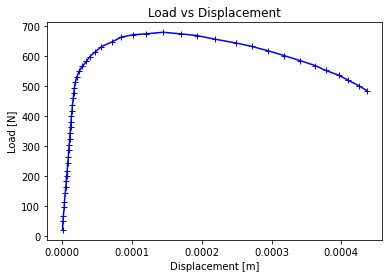

In [29]:
# PLOT EST DISPLACEMENT VS LOAD
plot1 = plt.figure()
ax = plot1.add_subplot(1,1,1)
ax.plot(df4['Displacement [m]'], df4['Exp Force [N]'], 'b+-')
ax.set_xlabel('Displacement [m]')
ax.set_ylabel('Load [N]')
ax.set_title('Load vs Displacement')
plot1_path = (results_dir+'/Val1_Load-Disp.png')
plot1.savefig(plot1_path)

In [30]:
df_output_csv_path=(results_dir+"/validation_data.csv")
df4.to_csv(df_output_csv_path, index=True, header=True)